In [1]:
from dependencies import *

_ColormakerRegistry()

# Preprocess data

Read in geometries

In [256]:
np.random.seed(429)

data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]

# for struct in data['processed']:
#     struct[-1].position[2] += np.random.normal(scale = 0.5) # add a bit of noise to z coord; reduce overfitting

data = pd.concat([data, getSOAPs(data['processed'])], axis = 1)

originalColumns = data.columns

data = pd.concat([pd.DataFrame(data['SOAP'].to_list(), index = data.index), data], axis = 1)

Independent test data:

In [5]:
# data2 = readStructs("../adsorb_amorphous2/", -196.0817, -16286.2542) #MeF, amorphous slab 2, DFTB

# data2['processed'] = [
#     convertAdsorbateToHe(i, 355, np.arange(355, 360)) for i in data2['geom']
# ]

# data2 = pd.concat([data2, getSOAPs(data2['processed'])], axis = 1)

# originalColumns = data2.columns

# data2 = pd.concat([pd.DataFrame(data2['SOAP'].to_list(), index = data2.index), data2], axis = 1)

# Visualize data

Summarize data:

In [5]:
data["E_ads"].describe()

count    93.000000
mean      0.409439
std       0.814419
min      -0.458600
25%      -0.180300
50%      -0.122800
75%       1.495000
max       1.621400
Name: E_ads, dtype: float64

In [20]:
data.loc[data['E_ads'] < -0.4, originalColumns]

,E,geom,E_ads,processed,SOAP
6,-17025.2714,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",-0.4094,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.0048074e-10, -6.624648e-09, 3.145716e-08, -..."
24,-17025.3206,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",-0.4586,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.6356706e-09, -1.5346345e-08, 3.7105632e-08,..."


In [28]:
np.bitwise_and(data['E_ads'] < 0 , data['E_ads'] > -0.1)

0      False
1      False
2      False
3       True
4      False
       ...  
102     True
103    False
104    False
105    False
106    False
Name: E_ads, Length: 93, dtype: bool

In [35]:
view(data.loc[np.bitwise_and(data['E_ads'] < 0, data['E_ads'] < -0.4), 'geom'])

In [37]:
view(data.loc[6, 'geom'])

In [33]:
view(gen.read_gen('../adsorb_amorphous/output3.gen'))

In [34]:
(data.loc[np.bitwise_and(data['E_ads'] < 0, data['E_ads'] < -0.4), originalColumns])

,E,geom,E_ads,processed,SOAP
6,-17025.2714,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",-0.4094,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.0048074e-10, -6.624648e-09, 3.145716e-08, -..."
24,-17025.3206,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",-0.4586,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.6356706e-09, -1.5346345e-08, 3.7105632e-08,..."


# Adaptive sampling?

# Train

For now, just remove points that have positive adsorption energy 

In [257]:
from sklearn.model_selection import train_test_split
validData = data['E_ads'] < 0
X_train = data.loc[validData, ~np.isin(data.columns, originalColumns)]
y_train = data.loc[validData, 'E_ads']
# X_train, X_test, y_train, y_test = train_test_split(
#     data.loc[validData, ~np.isin(data.columns, originalColumns)], 
#     data.loc[validData, 'E_ads'], random_state = 429)
# print("# points total: %d; #train points: %d; #test points: %d" % 
#       (sum(validData), len(X_train), len(X_test)))

Run KRR with grid CV search

In [258]:
alphas = np.logspace(-10, -2, 50)
krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
Emodel = GridSearchCV(krr, [{"alpha":alphas}], cv = 5)
Emodel.fit(np.array(X_train), np.array(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-10, 1.45634848e-10, 2.12095089e-10, 3.08884360e-10,
       4.49843267e-10, 6.55128557e-10, 9.54095476e-10, 1.38949549e-09,
       2.02358965e-09, 2.94705170e-09, 4.29193426e-09,...
       1.67683294e-05, 2.44205309e-05, 3.55648031e-05, 5.17947468e-05,
       7.54312006e-05, 1.09854114e-04, 1.59985872e-04, 2.32995181e-04,
       3.39322177e-04, 4.94171336e-04, 7.19685673e-04, 1.04811313e-03,
       1.52641797e-03, 2.22299648e-03, 3.23745754e-03, 4.71486636e-03,
       6.86648845e-03, 1.00000000e-02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Optimal model result:

In [259]:
Emodel.best_params_

{'alpha': 1.6768329368110066e-05}

In [260]:
# with open('Emodel.pkl', 'wb') as f:
#     pickle.dump(Emodel, f)

## Optimizing SOAP

In [10]:
def predictZs(slabs):
    bareslab = slabs[0].copy()
    del bareslab[-1]
    
    testZstructs = []
    
    for slab in slabs:
        x, y, z = slab[-1].position
        maxz = 0
        for atom in slab:
            if atom.symbol == "He": # don't use He position to determine max Z position 
                continue
            _x, _y, _z = atom.position
            if ((x - _x)**2 + (y - _y)**2) ** 0.5 < 2.2:
                if _z > maxz:
                    maxz = _z

        newstruct = bareslab.copy()
        newheight = maxz + 2.5 #mean height from test; 
        # see https://docs.google.com/presentation/d/13NdBmWkxwG0ZvL7BgYsGo-x-3CzZp8JymnF8yTitdCg/edit#slide=id.ga11af18809_0_13

        newstruct.append(Atom("He", position = (x, y, newheight)))
        testZstructs += [newstruct]    
        
    return testZstructs
# predictZs(data['processed']) == testZstructs

In [58]:
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

def f(args, data):
    np.random.seed(429)
#     rcut,nmax,lmax,sigma, scale = args
#     nmax = int(nmax)
#     lmax = int(lmax)
    rcut, sigma, scale = args
    nmax = 10
    lmax = 9
    for struct in data['processed']:
        struct[-1].position[2] += np.random.normal(scale = scale) # add a bit of noise to z coord; reduce overfitting

    data = pd.concat([data, getSOAPs(data['processed'], 
                                     rcut = rcut, 
                                     nmax = nmax, 
                                     lmax = lmax, 
                                     sigma = sigma
                                    )], axis = 1)

    originalColumns = data.columns

    data = pd.concat([pd.DataFrame(data['SOAP'].to_list(), index = data.index), data], axis = 1)

    validData = data['E_ads'] < 0

    #train KRR on whole dataset
    X_train = data.loc[validData, ~np.isin(data.columns, originalColumns)] 
    Y_train = data.loc[validData, 'E_ads']
#     print(X_train, Y_train)

    alphas = np.logspace(-10, -2, 50)
    krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
    model = GridSearchCV(krr, [{"alpha":alphas}], cv = 5, n_jobs = 4)
    model.fit(np.array(X_train), np.array(Y_train))

    # generate the 'noisy/test' data
    newdata = data[originalColumns]
    newdata = newdata.drop('SOAP', axis = 1)
    newdata['testZstructs'] = predictZs(data['processed'])
    newdata = pd.concat([newdata, 
                         getSOAPs(newdata['testZstructs'],
                                  rcut = rcut,
                                  nmax = nmax, 
                                  lmax = lmax,
                                  sigma = sigma
                                 )], axis = 1)
    newdata = newdata[newdata["E_ads"] < 0] # filter valid structs
    newX = pd.DataFrame(newdata['SOAP'].to_list(), index = newdata.index)

    newdata['testEads'] = model.predict(newX)
    newdata['errors'] = newdata['E_ads'] - newdata['testEads']
    print(np.abs(np.mean(newdata['errors'])), rcut, sigma, scale)

    return np.abs(np.mean(newdata['errors']))

mydata = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
mydata['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in mydata['geom']
]

# guesses = [5, 10, 9, .1, 0.5]
guesses = [5, .1, 0.5]
bounds = [(1, None),
          (0, None),
          (0, None)
]
result = minimize(f, x0 = guesses, args = (mydata), bounds = bounds)

0.0012777788752003972 5.0 0.1 0.5
0.0022917501414224735 5.00000001 0.1 0.5
0.00050135852914354 5.0 0.10000001 0.5
5.5357097479043675e-05 5.0 0.1 0.50000001
6.144074524486362e-05 4.999972378585766 0.6361456999627331 1.3441254572920593
0.016283310356580274 4.999972388585766 0.6361456999627331 1.3441254572920593
0.005245694457853478 4.999972378585766 0.6361457099627331 1.3441254572920593
0.030477123300663975 4.999972378585766 0.6361456999627331 1.3441254672920593
0.0167471184476662 4.9999840133755065 0.41030851304173477 0.9885599483334109
0.018630920060651708 4.999984023375506 0.41030851304173477 0.9885599483334109
0.023372309054812933 4.9999840133755065 0.41030852304173476 0.9885599483334109
0.02558383158889533 4.9999840133755065 0.41030851304173477 0.9885599583334109
0.014844434049679122 4.999990854991042 0.2775092754973011 0.7794764526940281
0.030761909149031326 4.999990864991042 0.2775092754973011 0.7794764526940281
0.041217915481462725 4.999990854991042 0.2775092854973011 0.779476452

In [49]:
result.x

array([5. , 0.1, 0.5])

In [55]:
data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]
f([5, .1, 0.5],data)

0.002346843025654266 5 0.1 0.5


0.002346843025654266

In [56]:
f([5, .1, 0.5],data)

0.00394504982176187 5 0.1 0.5


0.00394504982176187

# Assess

NameError: name 'y_test' is not defined

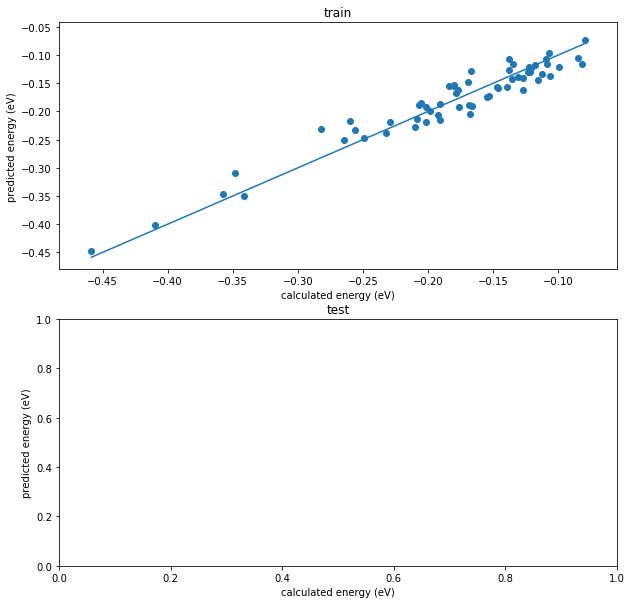

In [9]:
plt.subplots(2, 1, figsize = (10, 10))

plt.subplot(211)
plt.title('train')
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
train_predict = model.predict(X_train)
plt.scatter(y_train, train_predict)
lineparams = [min(y_train), max(y_train)]
plt.plot(lineparams, lineparams)
plt.subplot(212)
plt.title("test")
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
plt.scatter(y_test, model.predict(X_test))
plt.plot(lineparams, lineparams);

## Plot residuals

Considering the true model should simply be y = x, we can plot residuals and assess MAE easily:

In [10]:
train_errs = y_train - model.predict(X_train)

In [11]:
test_errs = y_test - model.predict(X_test)

NameError: name 'y_test' is not defined

NameError: name 'y_test' is not defined

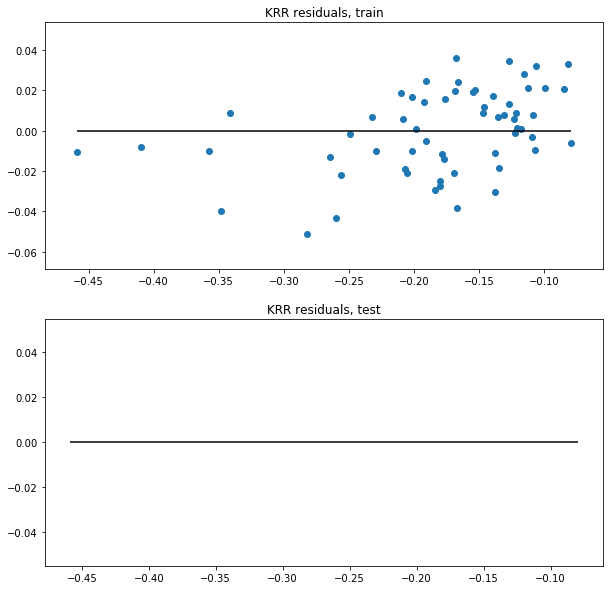

In [12]:
plt.subplots(2, 1, figsize = (10, 10))
plt.subplot(211)
plt.title("KRR residuals, train")
plt.scatter(y_train, train_errs);
plt.hlines(0, *lineparams)
plt.subplot(212)
plt.title("KRR residuals, test")
plt.hlines(0, *lineparams)
plt.scatter(y_test, test_errs);

In [13]:
print("MAE train (eV): %f \n\
MAE test (eV): %f" % 
      (np.mean(np.abs(train_errs)),
       np.mean(np.abs(test_errs))
      ))

NameError: name 'test_errs' is not defined

In [14]:
print("Relative absolute error train (eV): %f \n\
Relative absolute error test (eV): %f" % 
      (np.mean(np.abs(train_errs))/np.abs(np.mean(y_train)),
       np.mean(np.abs(test_errs)/np.abs(np.mean(y_test)))
      ))

NameError: name 'test_errs' is not defined

# Apply

Obtain the bare slab:

In [15]:
bareslab = data['processed'][0].copy()
del bareslab[[atom.symbol == 'He' for atom in bareslab]]
view(bareslab)

Try to predict z coordinate based on (x,y) position, using rule based method:

In [79]:
# find optimal rcut
stds = []
for searchR in np.arange(0, 4, 0.1):
    errors = []
    for slab in data['processed']:
        x, y, z = slab[-1].position
        maxz = 0
        for atom in slab:
            if atom.symbol == "He": # don't use He position to determine max Z position 
                continue
            _x, _y, _z = atom.position
            if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
                if _z > maxz:
                    maxz = _z

        errors += [z - maxz]
    stds += [np.std(errors)]
plt.plot(np.arange(0, 4, 0.1), stds)
plt.vlines(2.2, 0.5, 6, label = 'min at 2.2')
plt.legend()
plt.xlabel('radial cutoff')
plt.ylabel('SD of (z_surfmax - z_ads)')

KeyboardInterrupt: 

2.401963612489196


Text(0, 0.5, 'z_surfmax - z_ads')

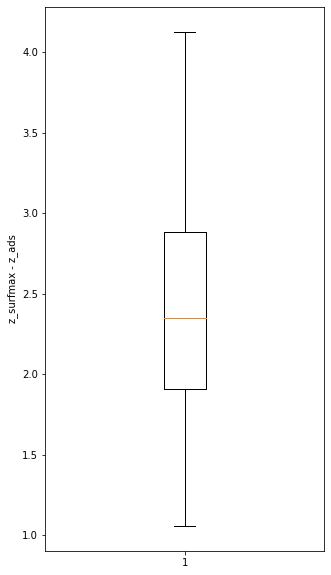

In [81]:
# use optimal rcut to find z offset and generate structs with that offset
plt.figure(figsize = (5,10))
searchR = 2.2
testZstructs = []
actualZstructs = []

errors = []
for slab in data['processed']:
    x, y, z = slab[-1].position
    maxz = 0
    for atom in slab:
        if atom.symbol == "He": # don't use He position to determine max Z position 
            continue
        _x, _y, _z = atom.position
        if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
            if _z > maxz:
                maxz = _z

    errors += [z - maxz]
    newstruct = bareslab.copy()
    newheight = maxz + 2.5 #mean height from test; 
    # see https://docs.google.com/presentation/d/13NdBmWkxwG0ZvL7BgYsGo-x-3CzZp8JymnF8yTitdCg/edit#slide=id.ga11af18809_0_13
    
    newstruct.append(Atom("He", position = (x, y, newheight)))
    testZstructs += [newstruct]    
#     actualZstructs += [bareslab.copy()]
#     add_adsorbate(acutalZstructs[-1], "He", height = 
plt.boxplot(errors)
# plt.legend()
print(np.mean(errors))
plt.ylabel('z_surfmax - z_ads')

## Assess mean error across sampled points

### Using rule based system

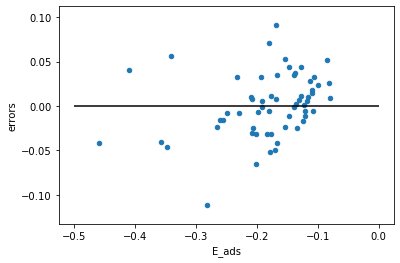

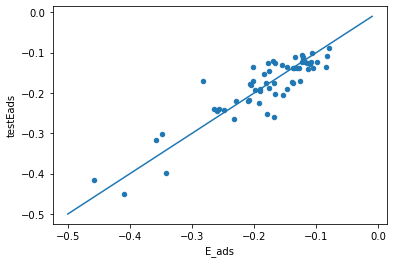

In [82]:
# append newstructs to data
newdata = data[originalColumns]
newdata = newdata.drop('SOAP', axis = 1)
newdata['testZstructs'] = testZstructs
newdata = pd.concat([newdata, 
                     getSOAPs(newdata['testZstructs'])], axis = 1)
newdata_cols = newdata.columns
newdata = newdata[newdata["E_ads"] < 0] # filter valid structs
newX = pd.DataFrame(newdata['SOAP'].to_list(), index = newdata.index)

newdata['testEads'] = model.predict(newX)
newdata['errors'] = newdata['E_ads'] - newdata['testEads']

newdata.plot('E_ads', 'errors', kind = 'scatter')
plt.hlines(0, -0.5, 0)

newdata.plot('E_ads', 'testEads', kind = 'scatter')
plotx = np.arange(-0.5, 0, 0.01)
plt.plot(plotx, plotx)

In [83]:
print("MAE rule-based (eV): %f " % 
      (np.mean(np.abs(newdata["E_ads"] - newdata["testEads"]))
      ))

MAE rule-based (eV): 0.027297 


### By minimizing energy

In [ ]:
# set range around guessed Z position to search for min E
Zrange = 2
# set range around guessed Z position to search for min E
numsearch = 10

newdata = data[originalColumns].drop('SOAP', axis = 1)
newdata['testZstructs'] = testZstructs
newdata = newdata[newdata["E_ads"] < 0] # filter valid structs
i = 0
minZs, minEs = [], []
for struct in newdata['testZstructs']: #iterate through the testZstruct for each original strcut
    
    
    x, y, z = struct[-1].position # assume adsorbate is last thing in list
    tempstructs = []
    zSearch = np.linspace(z - Zrange/2, z + Zrange/2, numsearch)
    for zTemp in zSearch:
        tempstruct = struct.copy()
        tempstruct[-1].position = [x, y, zTemp]
        tempstructs += [tempstruct]
    tempstructs = pd.Series(tempstructs)
    
    tempSOAPs = getSOAPs(tempstructs)
    tempdata = pd.DataFrame(tempSOAPs.to_list())
    tempEs = model.predict(tempdata)
    minE = np.min(tempEs)
#     minZ = zSearch[tempEs == minE][0]
#     minZs += [minZ]
    minEs += [minE]
# newdata['minZ'] = minZs
newdata['minE'] = minEs
# newdata['actualZ'] = [slab[-1].position[-1] for slab in newdata['processed']]
newdata.head()

In [ ]:
newdata.plot('E_ads', 'minE', kind = 'scatter')
plt.plot(newdata['E_ads'], newdata['E_ads'])

In [ ]:
plt.scatter(newdata["E_ads"], newdata["E_ads"] - newdata["minE"])
plt.hlines(0, -0.5, 0)
plt.xlabel("E_ads")
plt.ylabel("E_ads - avg(E_pred)")

In [ ]:
print("MAE min (eV): %f " % 
      (np.mean(np.abs(newdata["E_ads"] - newdata["minE"]))
      ))

# Prediction of z coordinate

Some pseudocode:

    1) Take all training points, isolate their (x,y) coordinates; generate range of points at $ z_{surf} + 2.5 \pm 1 Å $. 
    2) Set $z_true$ for all those points to be actual z value. 
    3) Run the predictive model; hope it works??? 

In [22]:
np.random.seed(429)

zrange = 3
zstep = 0.25
zdiffs = np.arange(-zrange, zrange, zstep)

data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
validData = data['E_ads'] < 0
data = data.loc[validData, :]
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]
data['truez'] = [s[-1].position[2] for s in data['processed']]

newdata = data.copy()
newdata = newdata.iloc[0:0]


for idx, row in data.iterrows():
    truez = row['truez']
    for zdiff in zdiffs:
        newrow = row.copy()
        tempStruct = newrow['processed'].copy()
        tempStruct[-1].position[2] = truez + zdiff
        newrow['processed'] = tempStruct
        newdata = newdata.append(newrow) 
    
newdata = newdata.reset_index(drop = True)

newdata = newdata.sample(frac = 1)

newdata = pd.concat([newdata, getSOAPs(newdata['processed'])], axis = 1)


originalColumns = newdata.columns

X = pd.DataFrame(newdata['SOAP'].to_list(), index = newdata.index)
y = newdata['truez']
newdata = pd.concat([X, newdata], axis = 1)

In [6]:
# X_train = newdata.loc[:, ~np.isin(newdata.columns, originalColumns)]
# y_train = newdata.loc[:, 'truez']
# X_train, X_test, y_train, y_test = train_test_split(
#     newdata.loc[:, ~np.isin(newdata.columns, originalColumns)], 
#     newdata.loc[:, 'truez'], test_size= 0.0001, random_state = 429)
# print("# points total: %d; #train points: %d; #test points: %d" % 
#       (sum(validData), len(X_train), len(X_test)))

In [23]:
## load model
# with open('zmodel.pkl', 'rb') as f:
#     zmodel = pickle.load(f)

#fit model

print(X.shape)

# X = X.sample(frac = 1)
    
alphas = np.logspace(-10, -2, 5)
krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
zmodel = GridSearchCV(krr, [{"alpha":alphas}], cv = 5)
zmodel.fit(np.array(X), np.array(y))

print(zmodel.best_params_)

#save model 

# with open('zmodel.pkl', 'wb') as f:
#     pickle.dump(zmodel, f)

(1440, 5500)
{'alpha': 0.0001}


In [24]:
with open('zmodel.pkl', 'wb') as f:
    pickle.dump(zmodel, f)

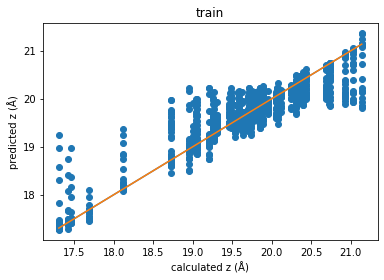

In [25]:
# plt.subplots(2, 1, figsize = (10, 10))

# print(X_train.shape)

# plt.subplot(211)
plt.title('train')
plt.ylabel("predicted z (Å)")
plt.xlabel("calculated z (Å)")
train_predict = zmodel.predict(X)
plt.scatter(y, train_predict)
lineparams = [min(y), max(y)]
plt.plot(lineparams, lineparams)
# plt.subplot(212)
# plt.title("test")
# plt.ylabel("predicted z (Å)")
# plt.xlabel("calculated z (Å)")
# plt.scatter(y_test, zmodel.predict(X_test))
plt.plot(lineparams, lineparams);

In [45]:
train_errs = y_train - zmodel.predict(X_train)

NameError: name 'y_train' is not defined

In [46]:
test_errs = y_test - zmodel.predict(X_test)

NameError: name 'y_test' is not defined

NameError: name 'y_train' is not defined

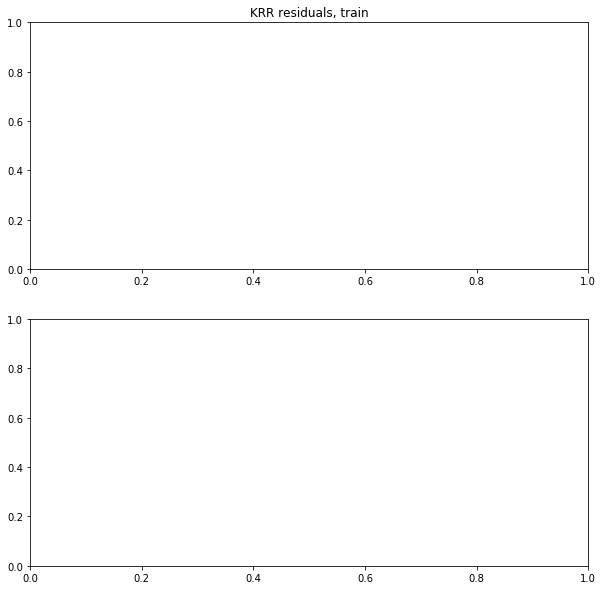

In [47]:
plt.subplots(2, 1, figsize = (10, 10))
plt.subplot(211)
plt.title("KRR residuals, train")
plt.scatter(y_train, train_errs);
plt.hlines(0, *lineparams)
plt.subplot(212)
plt.title("KRR residuals, test")
plt.hlines(0, *lineparams)
plt.scatter(y_test, test_errs);

In [202]:
print("MAE train (Å): %f \n\
MAE test (Å): %f" % 
      (np.mean(np.abs(train_errs)),
       np.mean(np.abs(test_errs))
      ))

MAE train (Å): 0.080613 
MAE test (Å): 0.514757


# Apply both models, chained

First, load the models

In [5]:
with open('zmodel.pkl', 'rb') as f:
    zmodel = pickle.load(f)
with open('Emodel.pkl', 'rb') as f:
    Emodel = pickle.load(f)

Next, read and process the training data that we have:

    1) Read training structures
    2) Filter data to only keep valid data
    3) Convert adsorbates to He points
    4) Use rule-based method and set the height of the He point to be result
    5) Obtain SOAP representation of each training structure, now with He
    6) Get the SOAP matrix and corresponding data for each training structure

In [6]:
np.random.seed(429)
searchR = 2.2

 actual structures (training points) 
data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB

## filter out wrong adsorption energies
validData = data['E_ads'] < 0
data = data.loc[validData, :]

## turn adsorbate molecule 
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]

ztrue = np.array([])

for struct in data['processed']:
    ## calculate initial guess for z position of adsorbate
    
    maxz = 0
    x,y,z = struct[-1].position
    ztrue = np.append(ztrue, z)
    
    for atom in struct:
        if atom.symbol == "He": # don't use He position to determine max Z position 
            continue
        _x, _y, _z = atom.position
        if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
            if _z > maxz:
                maxz = _z 
    newheight = maxz + 2.5
    
    ## set the rule based guess as the z position of adsorbate
    
    struct[-1].position[2] = newheight 
data['ztrue'] = ztrue
    
originalColumns = data.columns

## generate SOAP representations
    
data = pd.concat([data, getSOAPs(data['processed'])], axis = 1)

# data = data.sample(frac = 1)

## generate data matrix for assessment via ML 
X = pd.DataFrame(data['SOAP'].to_list(), index = data.index)

## generate target vectors

Eads = data['E_ads']
ztrue =  data['ztrue']

First, get KRR predicted z value and show prediction improvement

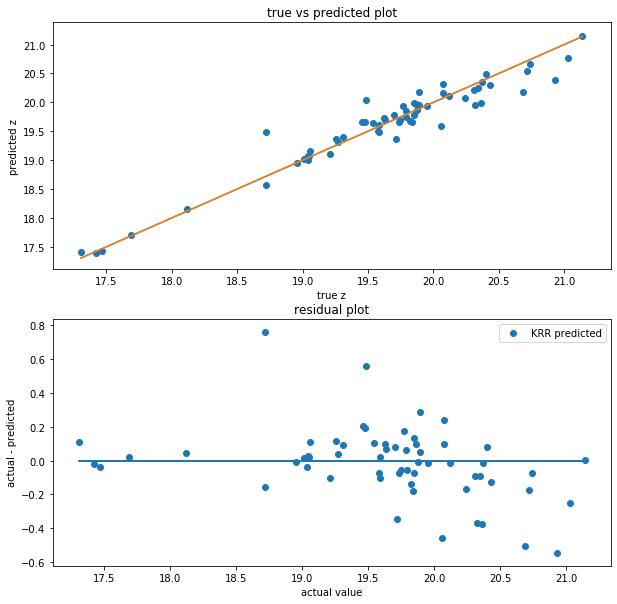

In [7]:
data['predicted z'] = zmodel.predict(X)
lineparams = [min(ztrue), max(ztrue)]
currzs = [atoms[-1].position[2] for atoms in data['processed']]

fig, ax = plt.subplots(2, 1, figsize = (10, 10))

plt.subplot(211)
plt.title('true vs predicted plot')
plt.xlabel("true z")
plt.ylabel("predicted z")
plt.plot(lineparams, lineparams)
plt.scatter(data['ztrue'], data['predicted z'])
plt.plot(lineparams, lineparams)
plt.subplot(212)
plt.title("residual plot")
plt.xlabel("actual value")
plt.ylabel("actual - predicted")
plt.scatter(ztrue, (data['predicted z'] - data['ztrue']), label = 'KRR predicted')
# plt.scatter(ztrue, np.abs(currzs - data['ztrue']), label = 'rule based')
plt.plot(ztrue, ztrue * 0)
plt.legend()


# print("MAE test (Å): %f" % 
#       (np.mean(np.abs(train_predict - Eads)),
#       ))

Replace the z positions with the predicted z; regenerate SOAP for that 

In [8]:
data = data.drop('SOAP', axis = 1)
for i, row in data.iterrows():
    atoms = row['processed']
    row['processed'][-1].position[2] = row['predicted z']
    
data = pd.concat([data, getSOAPs(data['processed'])], axis = 1)


X = pd.DataFrame(data['SOAP'].to_list(), index = data.index)


MAE test (Å): 0.012580


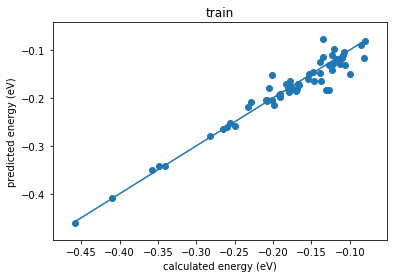

In [9]:
# plt.subplots(2, 1, figsize = (10, 10))

# plt.subplot(211)
plt.title('train')
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
train_predict = Emodel.predict(X)
plt.scatter(Eads, train_predict)
lineparams = [min(Eads), max(Eads)]
plt.plot(lineparams, lineparams)
# plt.subplot(212)
# plt.title("test")
# plt.ylabel("predicted energy (eV)")
# plt.xlabel("calculated energy (eV)")
# plt.scatter(y_test, Emodel.predict(X_test))
# plt.plot(lineparams, lineparams);

print("MAE test (Å): %f" % 
      (np.mean(np.abs(train_predict - Eads)),
      ))

# Use zpred and Epred to map the energy surface

In [16]:
with open('zmodel.pkl', 'rb') as f:
    zmodel = pickle.load(f)
with open('Emodel.pkl', 'rb') as f:
    Emodel = pickle.load(f)

Generate base slab structure

In [9]:
### read actual structures (training points) 
data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB

## filter out wrong adsorption energies
validData = data['E_ads'] < 0
data = data.loc[validData, :]

## turn adsorbate molecule 
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]

base = data['processed'][0].copy()
# base = gen.read_gen("../bomb0/output0-0.gen")
del base[[atom.index for atom in base if atom.symbol in ['He', 'Ar']]]
base.wrap()
view(base)

Grid over surface to map

In [10]:
def predictz(surf, x, y, zmodel = 'zmodel.pkl'):
    """
    surf: bare substrate
    x, y: position at which to place adsorbate
    zmodel: Path object pointing to the model pickle
    """
    searchR = 2.2
    surf = surf.copy()
    add_adsorbate(surf, 'He', height = 0, position = (x, y))
    
    maxz = 0
    for atom in surf:
        if atom.symbol == "He": # don't use He position to determine max Z position 
            continue
        _x, _y, _z = atom.position
        if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
            if _z > maxz:
                maxz = _z + 2.5
                
    surf[-1].position[2] = maxz
    
    X = getSOAPs(pd.Series({0: surf}))[0].reshape(1, -1) #reshape because just one sample
    if zmodel: 
        with open('zmodel.pkl', 'rb') as f:
            zmodel = pickle.load(f)
        
        predz = zmodel.predict(X)
    else:
#         TODO: implement me hehe 
        predz = maxz
    return predz

In [11]:
# assume cubic structure for cell

a,b,c = base.cell
a,b,c = np.linalg.norm(a), np.linalg.norm(b), np.linalg.norm(c)
npoints = 20
apoints = np.linspace(0, a, npoints)
bpoints = np.linspace(0, b, npoints)

# originalData = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
# originalData = originalData.loc[originalData['E_ads'] < 0, :]

gridpoints = []
for apoint in apoints:
    for bpoint in bpoints:
        newstruct = base.copy()
        zhat = predictz(newstruct, apoint, bpoint)
        newstruct.append(Atom('He', position = (apoint, bpoint, zhat)))
        gridpoints += [newstruct]
        

# originalZs = []
# for geom in originalData['geom']:
#     newstruct = base.copy()
#     apoint, bpoint, originalZ = geom[370].position
#     originalZs += [originalZ]
#     zhat = predictz(newstruct, apoint, bpoint, zmodel="zmodel.pkl")
# #     print(np.abs(originalZ - zhat))
#     newstruct.append(Atom('He', position = (apoint, bpoint, zhat)))
#     gridpoints += [newstruct]
        
gridpoints = pd.Series(gridpoints)
gridpoints = pd.DataFrame({'geom': gridpoints})

In [12]:
view(gridpoints['geom'])

In [13]:
gridpoints = pd.concat([gridpoints, getSOAPs(gridpoints['geom'])], axis = 1)
gridpoints.head()

,geom,SOAP
0,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.064327e-08, -1.0571978e-07, -1.4709317e-07,..."
1,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.213191e-11, 3.6122585e-09, -3.4000994e-08, ..."
2,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.1361363e-08, -8.26679e-08, -4.1391553e-07, ..."
3,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.7687133e-09, 1.1047682e-08, -2.2662132e-07,..."
4,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.8717523e-09, -3.179345e-08, 9.560936e-08, 7..."


In [14]:
X = pd.DataFrame(gridpoints['SOAP'].to_list(), index = gridpoints.index)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,5490,5491,5492,5493,5494,5495,5496,5497,5498,5499
0,3.064327e-08,-1.057198e-07,-1.470932e-07,1.844229e-06,-4.090615e-07,-3.139774e-06,-6.885270e-06,3.083769e-07,1.863786e-06,1.183898e-05,...,0.000780,-0.001112,0.001108,-0.000555,0.001752,-0.001852,0.000961,0.002020,-0.001065,0.000566
1,8.213191e-11,3.612258e-09,-3.400099e-08,1.129564e-07,-4.757247e-08,-1.146004e-07,-8.431510e-08,-1.336889e-07,-4.132656e-08,4.985039e-07,...,0.000331,-0.000317,0.000217,-0.000078,0.000304,-0.000208,0.000075,0.000142,-0.000051,0.000019
2,3.136136e-08,-8.266790e-08,-4.139155e-07,3.195697e-06,-3.556459e-06,-3.179361e-06,-4.027245e-07,1.149188e-06,-2.027394e-06,9.027733e-06,...,0.000316,-0.000298,0.000201,-0.000072,0.000282,-0.000190,0.000068,0.000128,-0.000046,0.000016
3,3.768713e-09,1.104768e-08,-2.266213e-07,9.086839e-07,-3.532762e-07,-1.872875e-06,2.869276e-07,2.486676e-07,-8.239413e-07,2.887975e-06,...,0.000174,-0.000155,0.000098,-0.000033,0.000138,-0.000087,0.000029,0.000055,-0.000019,0.000006
4,4.871752e-09,-3.179345e-08,9.560936e-08,7.325063e-08,-1.184580e-06,1.560686e-06,1.765605e-07,2.484651e-07,1.641037e-06,-3.260657e-06,...,0.000060,-0.000050,0.000029,-0.000009,0.000042,-0.000024,0.000008,0.000014,-0.000004,0.000001


In [17]:
predEs = Emodel.predict(X)

In [18]:
gridpoints['predE'] = predEs
gridpoints

,geom,SOAP,predE
0,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.064327e-08, -1.0571978e-07, -1.4709317e-07,...",-0.249615
1,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.213191e-11, 3.6122585e-09, -3.4000994e-08, ...",-0.140592
2,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.1361363e-08, -8.26679e-08, -4.1391553e-07, ...",-0.166568
3,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.7687133e-09, 1.1047682e-08, -2.2662132e-07,...",-0.157800
4,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.8717523e-09, -3.179345e-08, 9.560936e-08, 7...",-0.148129
...,...,...,...
395,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.800102e-09, -9.1894545e-09, 9.471556e-09, 1...",-0.221563
396,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.121737e-09, -1.8003904e-08, 3.8727993e-08, ...",-0.197281
397,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.2053543e-09, 1.1757077e-08, -1.4773269e-07,...",-0.214862
398,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[6.3065224e-09, -4.697195e-08, 1.6783822e-07, ...",-0.222954


In [19]:
charges = np.append(np.zeros(len(base)), gridpoints['predE'])
visbase = base.copy()
for geom in gridpoints['geom']:
    visbase.append(Atom("He", position = geom[-1].position)) 
visbase.set_initial_charges(charges)
view(visbase)

In [20]:
min(charges), max(charges)

(-0.4370635688632092, 0.0)

(0.8520906340905918, 5.817755831346991e-114)


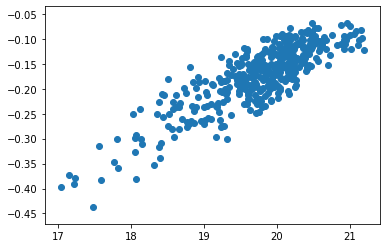

In [21]:
plt.scatter([geom[-1].position[2] for geom in gridpoints['geom']],
         gridpoints['predE']
        )
print(
pearsonr([geom[-1].position[2] for geom in gridpoints['geom']],
         gridpoints['predE']
        )
)

# Adaptive sampling based on Epred

In [22]:
gridpoints = gridpoints.sort_values(by = 'predE')
gridpoints

,geom,SOAP,predE
195,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.6382697e-09, -1.9743231e-08, 2.6733927e-08,...",-0.437064
215,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.12802e-11, -4.726763e-10, 3.2690313e-09, -8...",-0.396863
147,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[7.0423284e-10, -2.467503e-10, -3.0958862e-08,...",-0.391573
236,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[9.032491e-09, -6.4968106e-08, 2.1738117e-07, ...",-0.383273
128,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.098747e-10, -3.446277e-09, -2.3059834e-09, ...",-0.381468
...,...,...,...
202,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.531258e-09, -3.9727627e-08, 1.7419737e-07, ...",-0.078098
136,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.9455666e-09, -3.2489485e-08, 1.0117405e-07,...",-0.074719
156,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.35695e-09, -1.9410766e-08, 3.8746304e-08, 1...",-0.071507
137,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[5.3237375e-09, -3.966178e-08, 1.479871e-07, -...",-0.069087


In [23]:
gridpoints['xpos'] = [geom[-1].position[0] for geom in gridpoints['geom']]
gridpoints['ypos'] = [geom[-1].position[1] for geom in gridpoints['geom']]
gridpoints['zpos'] = [geom[-1].position[2] for geom in gridpoints['geom']]

In [24]:
gridpoints

,geom,SOAP,predE,xpos,ypos,zpos
195,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.6382697e-09, -1.9743231e-08, 2.6733927e-08,...",-0.437064,7.133590,11.889316,17.473442
215,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.12802e-11, -4.726763e-10, 3.2690313e-09, -8...",-0.396863,7.926211,11.889316,17.033941
147,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[7.0423284e-10, -2.467503e-10, -3.0958862e-08,...",-0.391573,5.548347,5.548347,17.216012
236,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[9.032491e-09, -6.4968106e-08, 2.1738117e-07, ...",-0.383273,8.718832,12.681937,17.585063
128,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.098747e-10, -3.446277e-09, -2.3059834e-09, ...",-0.381468,4.755726,6.340968,18.072694
...,...,...,...,...,...,...
202,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.531258e-09, -3.9727627e-08, 1.7419737e-07, ...",-0.078098,7.926211,1.585242,20.562712
136,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.9455666e-09, -3.2489485e-08, 1.0117405e-07,...",-0.074719,4.755726,12.681937,21.012271
156,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.35695e-09, -1.9410766e-08, 3.8746304e-08, 1...",-0.071507,5.548347,12.681937,20.886609
137,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[5.3237375e-09, -3.966178e-08, 1.479871e-07, -...",-0.069087,4.755726,13.474558,20.966857


In [31]:
mefCutoff = 4
adsorbatePoints = []
a = visbase.cell[0]
b = visbase.cell[1]
for i, row in gridpoints.iterrows():
    isclose = False
    point1 = np.array([row['xpos'], row['ypos']]) 
    for x, y, z in adsorbatePoints: 
        for dispx in [-a, a*0, a]:
            for dispy in [-b, b*0, b]:
                point2 = np.array([x, y])
                point2 = point2 + dispx[:2] + dispy[:2]
        
                if np.linalg.norm(point1 - point2) < mefCutoff:
                    isclose = True
    if not isclose:
        adsorbatePoints.append(np.append(point1, row['zpos']))
adsorbatePoints, len(adsorbatePoints)

([array([ 7.13358954, 11.88931591, 17.47344207]),
  array([ 5.54834742,  5.54834742, 17.21601196]),
  array([14.26717909, 11.09669485, 18.4012302 ]),
  array([12.68193697,  3.9631053 , 17.55901647]),
  array([ 3.9631053 ,  1.58524212, 18.96352119]),
  array([ 0.        ,  0.        , 19.71449663]),
  array([10.30407379, 15.05980015, 18.83973582]),
  array([ 9.51145273,  7.13358954, 20.41596068]),
  array([ 3.17048424, 10.30407379, 20.06587646]),
  array([ 1.58524212,  6.34096848, 20.11343636])],
 10)

In [26]:
adsvisbase = base.copy()
maxz = np.max([atom.position[2] for atom in adsvisbase])
for point in adsorbatePoints:
    add_adsorbate(adsvisbase, mef, height = point[2] - maxz + 1, position = (point[0], point[1]))
view(adsvisbase)

In [27]:
gen.write_gen("../input.gen", adsvisbase)

In [66]:
view(adsvisbase)

In [28]:
view(gen.read_gen("../input.gen"))